In [38]:
import pandas as pd
import numpy as np
import re
from pprint import pprint 
from datetime import datetime

#scrapping
import GetOldTweets3 as got
import time

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [39]:
def get_tweets(text_query, start_date, end_date, lang, location, within):
   
  # spesifik kriteria 
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(text_query)\
                          .setSince(start_date)\
                          .setUntil(end_date)\
                          .setLang(lang)\
                          .setNear(location)\
                          .setWithin(within)
    
   # scrapping tweet berdasarkan kriteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    #membuat list tweet dengan atribut tweet
    # specified in the list comprehension
    text_tweets = [[tw.username,
                tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.hashtags] for tw in tweet]
    
    # membuat dataframe, tweets corresponding to tweet attributes
    tw_df = pd.DataFrame(text_tweets, 
                         columns = ['User', 'Text', 'Date', 'Retweets', 'Favorites', 'HashTags'])
    
    return tw_df

In [40]:
text_query = 'dirumahaja'
start_date = '2020-05-03'
end_date = '2020-06-03'
lang = 'id'
within = '50mi'

citys = ['Jakarta, DKI Jakarta','Surabaya, Jawa Timur','Sidoarjo, Jawa Timur','Malang, Jawa Timur','Bangkalan, Jawa Timur','Pekanbaru, Riau','Tangerang, Banten','Makasar, Sulawesi Selatan','Semarang, Jawa Barat','Bandung, Jawa Barat']

In [41]:
# scrap membutuhkan info dan export ke file csv
for city in citys:
  location = city
  df = get_tweets(text_query,start_date,end_date,lang,location,within)
  df.to_csv(city + '.csv', index = False)
  time.sleep(120)

In [42]:
# menambahkan kolom kota dan mengkombinasi semua datasets
city_column = ['JKT','SBY','SDA','MLG','BKL','PKU','TGR','MKS','SMG','BDG']
dirumahaja = pd.DataFrame()
for i in range(len(city_column)):
  df = pd.read_csv(citys[i]+'.csv')
  df['City'] = city_column[i]
  dirumahaja = pd.concat([dirumahaja, df], axis = 0)

In [43]:
#export seluruh baris data
dirumahaja.to_csv('dirumahaja.csv', index = False)

In [44]:
df = pd.read_csv("dirumahaja.csv")
df.shape

(8547, 7)

In [45]:
df.replace('[]', np.nan, inplace = True)
df.drop_duplicates(inplace = True)
df.drop_duplicates(subset = ['Text'], inplace = True)

# memisahkan timestamp ke tanggal dan waktu
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].apply( lambda x: x.strftime("%Y-%m-%d"))
df['time'] = df['Date'].apply( lambda x: x.strftime("%H-%M-%S"))
df.drop(['Date'], axis = 1, inplace = True)

# mengganti kota dengan inisial nama kota
replace_values = {'JKT' : 'Jakarta','SBY':'Surabaya','SDA':'Sidoarjo','MLG':'Malang','BKL':'Bangkalan','PKU':'Pekanbaru','TGR':'Tangerang','MKS':'Makasar','SMG':'Semarang','BDG':'Bandung'}
df = df.replace({"City" : replace_values})

In [46]:
from numpy import *

In [47]:
# menghitung pengguna harian
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
unique_user = pd.DataFrame(df.groupby('date')['Text'].nunique())
lag_user = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis = 1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-05-24,455,500,1.098901,500,0
2020-05-25,194,211,1.087629,211,0
2020-05-26,119,128,1.075630,128,0
2020-05-27,97,109,1.123711,109,0
2020-05-28,97,106,1.092784,106,0
2020-05-29,100,125,1.250000,125,0
2020-05-30,129,147,1.139535,147,0
2020-05-31,118,139,1.177966,139,0
2020-06-01,104,121,1.163462,121,0


In [48]:
dates = sorted(df['date'].unique())
unique_user = list()
for date in dates:
  unique_user.append(df[df['date'] < date]['User'].nunique())

  lag_user = [0]+unique_user
  lag_user = lag_user[:-1]

In [49]:
lag_user

[0,
 0,
 173,
 294,
 416,
 542,
 679,
 770,
 892,
 1002,
 1102,
 1185,
 1274,
 1373,
 1460,
 1554,
 1649,
 1741,
 1855,
 1945,
 2036,
 2148,
 2345,
 2724,
 2852,
 2920,
 2978,
 3032,
 3093,
 3176,
 3248]

In [50]:
# memilih 2020-05-03 sebagai divisi
# old users: yang aktif di 05-03
# new_users: yang gaaktif until 05-03
existing_user= df[df['date'] < '2020-05-03']['User'].unique()

# retain all old users
df1 = df[df['User'].isin(existing_user)]                      
df2 = df[-df['User'].isin(existing_user)]

# sample new users
df2 = df2.sample(1300)

# get new sample
df = pd.concat([df1,df2])                                     

# export new sample
df.to_csv("Dirumahaja_Done_New.csv", index = False)
df.shape

(1300, 8)

[Text(0, 0, '2020-05-03'),
 Text(0, 0, '2020-05-04'),
 Text(0, 0, '2020-05-05'),
 Text(0, 0, '2020-05-06'),
 Text(0, 0, '2020-05-07'),
 Text(0, 0, '2020-05-08'),
 Text(0, 0, '2020-05-09'),
 Text(0, 0, '2020-05-10'),
 Text(0, 0, '2020-05-11'),
 Text(0, 0, '2020-05-12'),
 Text(0, 0, '2020-05-13'),
 Text(0, 0, '2020-05-14'),
 Text(0, 0, '2020-05-15'),
 Text(0, 0, '2020-05-16'),
 Text(0, 0, '2020-05-17'),
 Text(0, 0, '2020-05-18'),
 Text(0, 0, '2020-05-19'),
 Text(0, 0, '2020-05-20'),
 Text(0, 0, '2020-05-21'),
 Text(0, 0, '2020-05-22'),
 Text(0, 0, '2020-05-23'),
 Text(0, 0, '2020-05-24'),
 Text(0, 0, '2020-05-25'),
 Text(0, 0, '2020-05-26'),
 Text(0, 0, '2020-05-27'),
 Text(0, 0, '2020-05-28'),
 Text(0, 0, '2020-05-29'),
 Text(0, 0, '2020-05-30'),
 Text(0, 0, '2020-05-31'),
 Text(0, 0, '2020-06-01'),
 Text(0, 0, '2020-06-02')]

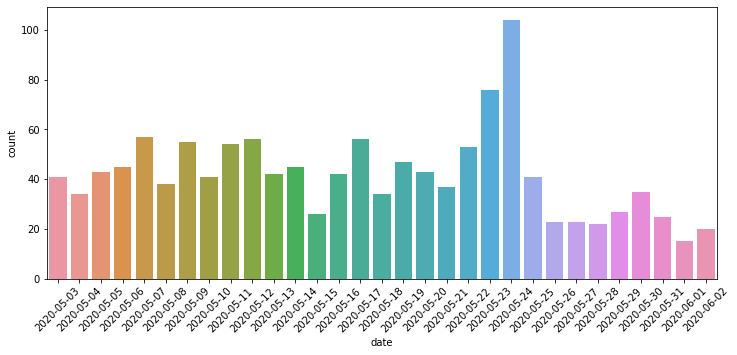

In [51]:
# memplot distribusi pada sample baru
fig = plt.figure(figsize = (12,5))
chart = sns.countplot(df['date'], order = sorted(df['date'].unique()))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

In [53]:
# menghitung pengguna perhari
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis =1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-05-24,102,104,1.019608,2345,197
2020-05-25,38,41,1.078947,2724,379
2020-05-26,23,23,1.000000,2852,128
2020-05-27,22,23,1.045455,2920,68
2020-05-28,22,22,1.000000,2978,58
2020-05-29,26,27,1.038462,3032,54
2020-05-30,32,35,1.093750,3093,61
2020-05-31,25,25,1.000000,3176,83
2020-06-01,15,15,1.000000,3248,72
